In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt


class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.3):
        super(MultiLabelClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], output_size),
            nn.Sigmoid()  # Sigmoid for multilabel classification
        )

    def forward(self, x):
        return self.network(x)


class CustomDataset(Dataset):
    def __init__(self, features, labels, sample_weights):
        self.features = features
        self.labels = labels
        self.sample_weights = sample_weights

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.sample_weights[idx]

In [15]:
data = pd.read_csv('~/Desktop/EHR/EHR work/RdataFiles/causal_prep/Sepsis/SepsisAllAbx.csv', sep='\t')
data['FEMALE'] = data.GENDER == 'FEMALE'
data.drop([
    'PERSON_ID', 'SEPSIS_DX_DATE', 'time', 'SEPDX_m_ADMIT', 'SEPSIS_DESCRIPTION', 'GENDER',
    'CULTURE_m_SEPDX', 'NUM_ABX_DAYS', 'FIRST_ABX_DAY', 'status', 'time_censored', 'TRT'
], axis=1, inplace=True)
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(float)

target_vars = ['TZP', 'CRO', 'FEP', 'MEM']
labels = torch.tensor(np.array(data.filter(items = target_vars))).float()
features = torch.tensor(np.array(data.drop(target_vars, axis=1))).float()

In [16]:
print(labels.shape)
print(features.shape)

torch.Size([30830, 4])
torch.Size([30830, 51])


In [30]:
# Hyperparameters
input_size = features.shape[1]  # Number of features
hidden_sizes = [128, 64]
output_size = labels.shape[1]   # Number of labels
dropout_rate = 0.3
learning_rate = 1e-3
batch_size = 32
num_epochs = 25
weight_decay = 1e-4

# Class weights
class_weights = 1 / labels.sum(axis=0)
class_weights = class_weights / class_weights.sum()
# Sample weights
uniq, idx, inv, counts = np.unique(np.array(labels), axis=0, return_index=True, return_counts=True, return_inverse=True)
sample_weights = np.array([1 / counts[i] for i in inv])
sample_weights = sample_weights / sample_weights.sum() * 1e5
sample_weights = torch.tensor(sample_weights)

# Dataset and Dataloader
dataset = CustomDataset(features, labels, sample_weights)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Optimizer, and Scheduler
model = MultiLabelClassifier(input_size, hidden_sizes, output_size, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [31]:
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_features, batch_labels, batch_sample_weights in dataloader:
        # Forward pass
        batch_outputs = model(batch_features)

        # Loss function
        loss = torch.nn.functional.binary_cross_entropy(batch_outputs, batch_labels, weight=class_weights, reduction='none')
        loss = loss * batch_sample_weights.unsqueeze(1)
        loss = loss.mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    # Learning rate adjustment
    scheduler.step(epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1/25, Loss: 0.5742
Epoch 2/25, Loss: 0.5597
Epoch 3/25, Loss: 0.5510
Epoch 4/25, Loss: 0.5463
Epoch 5/25, Loss: 0.5459
Epoch 6/25, Loss: 0.5445
Epoch 7/25, Loss: 0.5441
Epoch 8/25, Loss: 0.5445
Epoch 9/25, Loss: 0.5464
Epoch 10/25, Loss: 0.5425
Epoch 11/25, Loss: 0.5460
Epoch 12/25, Loss: 0.5448
Epoch 13/25, Loss: 0.5437
Epoch 14/25, Loss: 0.5420
Epoch 15/25, Loss: 0.5468
Epoch 16/25, Loss: 0.5431
Epoch 17/25, Loss: 0.5429
Epoch 18/25, Loss: 0.5428
Epoch 19/25, Loss: 0.5411
Epoch 20/25, Loss: 0.5449
Epoch 21/25, Loss: 0.5420
Epoch 22/25, Loss: 0.5419
Epoch 23/25, Loss: 0.5423
Epoch 24/25, Loss: 0.5424
Epoch 25/25, Loss: 0.5408


In [37]:
model.eval()
with torch.no_grad():
    y_prob = model(features).numpy()
y_true = np.array(labels).astype(int)
y_pred = (y_prob > 0.5).astype(int)
conf_mat = multilabel_confusion_matrix(y_true, y_pred)

In [68]:
# how to assess performance in terms of ability to predict label combinations?
pd.DataFrame(y_pred).to_csv('~/Desktop/EHR/EHR work/RdataFiles/causal_prep/Sepsis/NNpreds.csv', sep='\t', index=False)

# exact match ratio:
ex_match = np.all(y_pred == y_true, axis=1)
y_true[np.where(ex_match),:].shape
#ex_match.mean() # 10% are actually correct (3395)

(1, 3395, 4)

Text(0, 0.5, 'Frequency')

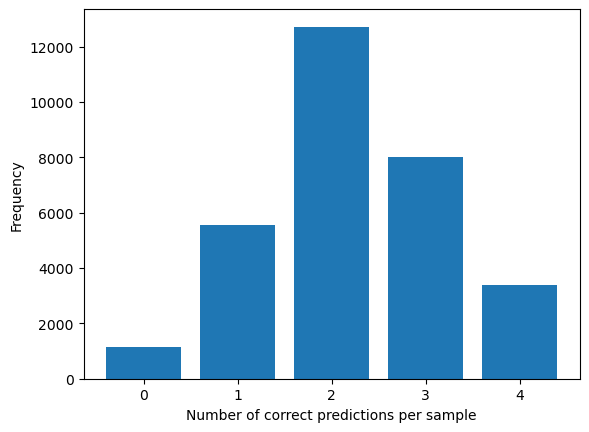

In [65]:
val, count = np.unique(np.sum(y_pred == y_true, axis=1), return_counts=True)
plt.bar(x=val, height=count)
plt.xlabel('Number of correct predictions per sample')
plt.ylabel('Frequency')

TZP
[[10163  6470]
 [ 7182  7015]]
CRO
[[ 4362  8267]
 [ 2804 15397]]
FEP
[[ 3945  5763]
 [ 6913 14209]]
MEM
[[ 2348   504]
 [16817 11161]]


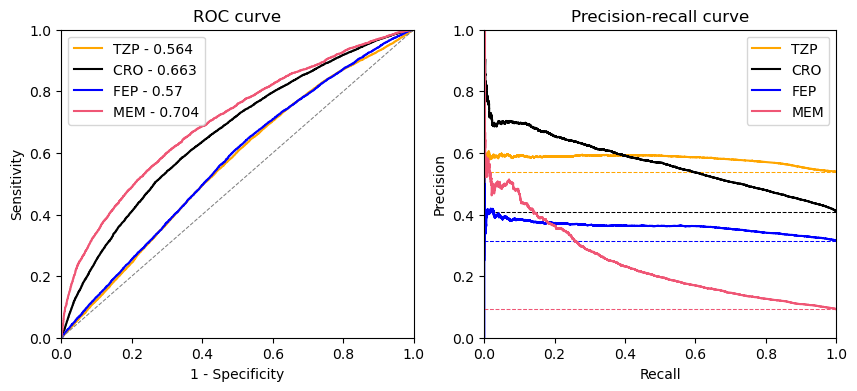

In [33]:
for i in range(4):
    var = target_vars[i]
    mat = np.flip(conf_mat[i])
    print(var)
    print(mat)

col_vec = ["#ffa600", "#000000", "#0000FF", "#ef5675"]

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1,2,1)
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
aurocs = []
for i in range(4):
    fpr, tpr, thresholds = roc_curve(y_true[:,i], y_prob[:,i])
    aurocs.append(round(roc_auc_score(y_true[:,i], y_prob[:,i]), 3))
    plt.plot(fpr, tpr, #label=target_vars[i], 
             color=col_vec[i])
plt.plot([0,1], [0,1], '--', color='gray', linewidth=0.75)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='upper left',
           labels = [var + ' - ' + str(auc) for var, auc in zip(target_vars, aurocs)])

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
for i in range(4):
    precision, recall, threshold = precision_recall_curve(y_true[:,i], y_prob[:,i])
    plt.plot(recall, precision, label=target_vars[i], color=col_vec[i])
    prevalence = y_true[:,i].sum() / y_true[:,i].size
    plt.plot([0, 1], [prevalence, prevalence], '--', color=col_vec[i], linewidth=0.75)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.legend(loc='upper right')
plt.show()